In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

data = pd.read_csv("RFLFSODataFull.csv")

weather_mapping = dict(zip(
    [0, 3, 4, 5, 6, 7, 8],
    ['Clear Weather', 'Duststorm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']
))

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

features = data.drop(columns=["RFL_Att", "FSO_Att"])
target_rf = data["RFL_Att"]
target_fso = data["FSO_Att"]

X_train, X_test, y_rf_train, y_rf_test, y_fso_train, y_fso_test = train_test_split(
    features, target_rf, target_fso, test_size=0.2, random_state=42
)

In [ ]:
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X_train, y_rf_train)

importances = rf_temp.feature_importances_
feature_names = np.array(X_train.columns)
sorted_idx = np.argsort(importances)[::-1]
rf_selected_features = feature_names[sorted_idx[:10]]
print("[RF] Selected features:", rf_selected_features)

X_train_rf = X_train[rf_selected_features]
X_test_rf = X_test[rf_selected_features]

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_rf, y_rf_train)
rf_model = rf_search.best_estimator_
print("[RF] Best Params:", rf_search.best_params_)

[RF] Selected features: ['RainIntensity' 'AbsoluteHumidity' 'Distance' 'RainIntensityMax'
 'RainIntensityMin' 'Temperature' 'SYNOPCode' 'RelativeHumidity'
 'ParticulateMax' 'Frequency']
[RF] Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [ ]:
rf_train_pred = rf_model.predict(X_train_rf)
X_train_new = X_train_rf.copy()
X_train_new["Predicted_RF_Att"] = rf_train_pred

rf_test_pred = rf_model.predict(X_test_rf)
X_test_new = X_test_rf.copy()
X_test_new["Predicted_RF_Att"] = rf_test_pred

fso_temp = RandomForestRegressor(n_estimators=100, random_state=42)
fso_temp.fit(X_train_new, y_fso_train)

importances_fso = fso_temp.feature_importances_
sorted_features_fso = np.array(X_train_new.columns)[np.argsort(importances_fso)[::-1]]
fso_selected_features = sorted_features_fso[:8]
print("[FSO] Selected features:", fso_selected_features)

if any(f not in X_test_new.columns for f in fso_selected_features):
    raise ValueError("Missing selected features in test set.")

fso_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

X_train_fso = X_train_new[fso_selected_features]
fso_search.fit(X_train_fso, y_fso_train)
fso_model = fso_search.best_estimator_
print("[FSO] Best Params:", fso_search.best_params_)


[FSO] Selected features: ['Distance' 'ParticulateMax' 'Temperature' 'Predicted_RF_Att'
 'AbsoluteHumidity' 'RelativeHumidity' 'SYNOPCode' 'RainIntensityMin']
[FSO] Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np


In [ ]:
X_test_fso = X_test_new[fso_selected_features]
fso_test_pred = fso_model.predict(X_test_fso)

mse = mean_squared_error(y_fso_test, fso_test_pred)
fso_rmse = np.sqrt(mse)
fso_r2 = r2_score(y_fso_test, fso_test_pred)
pear_corr, _ = pearsonr(rf_test_pred, fso_test_pred)

print("\n=== Overall Test Results ===")
print(f"[FSO Test] RMSE = {fso_rmse:.3f}, R² = {fso_r2:.3f}")
print(f"[RF vs. FSO Test] Pearson Corr = {pear_corr:.3f}")



=== Overall Test Results ===
[FSO Test] RMSE = 1.330, R² = 0.882
[RF vs. FSO Test] Pearson Corr = 0.088



=== Final Results (Using Global Model) ===
         Weather   RF RMSE     RF R²  FSO RMSE    FSO R²  Pearson Corr  \
0  Clear Weather  0.332955  0.983035  0.824880  0.945120     -0.289035   
1      Duststorm  0.430796  0.979392  1.687000  0.957344     -0.444290   
2            Fog  0.284002  0.970955  0.735508  0.965269      0.576308   
3        Drizzle  0.361823  0.984227  0.765730  0.954205     -0.172736   
4           Rain  0.550991  0.981416  0.775678  0.967625      0.357050   
5           Snow  0.363775  0.943683  1.007523  0.963731      0.786603   
6        Showers  0.644214  0.956153  0.744629  0.964877     -0.225825   

   Mutual Info (norm)  
0            0.038719  
1            0.210842  
2            0.120964  
3            0.047300  
4            0.042344  
5            0.082077  
6            0.077321  


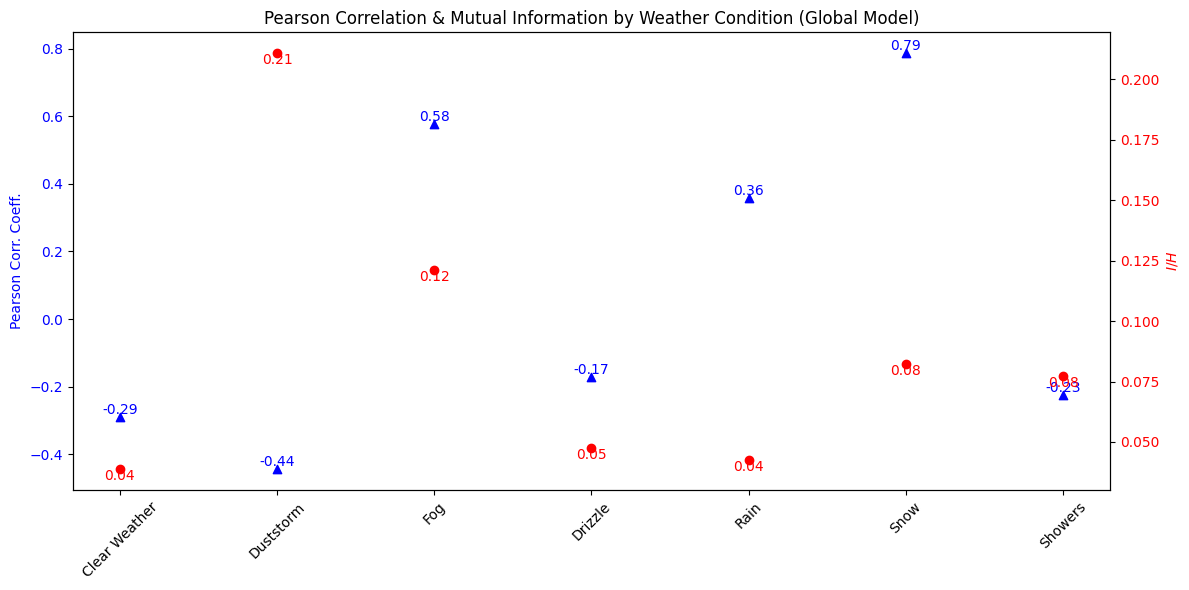

In [ ]:
pearson_corr_list, mutual_info_list = [], []
weather_conditions = []
rf_rmse_list, rf_r2_list = [], []
fso_rmse_list, fso_r2_list = [], []

for code, label in weather_mapping.items():
    subset = data[data['SYNOPCode'] == code]
    if len(subset) < 10:
        continue

    X_sub = subset.drop(['RFL_Att', 'FSO_Att'], axis=1)
    y_rf_sub = subset['RFL_Att']
    y_fso_sub = subset['FSO_Att']

    try:
        X_sub_rf = X_sub[rf_selected_features]
    except KeyError as e:
        print(f"[Warning] {label} - Missing feature in RF model: {e}")
        continue

    rf_sub_pred = rf_model.predict(X_sub_rf)
    X_sub_new = X_sub_rf.copy()
    X_sub_new['Predicted_RF_Att'] = rf_sub_pred

    try:
        X_sub_fso = X_sub_new[fso_selected_features]
    except KeyError as e:
        print(f"[Warning] {label} - Missing feature in FSO model: {e}")
        continue

    fso_sub_pred = fso_model.predict(X_sub_fso)

    rf_rmse = np.sqrt(mean_squared_error(y_rf_sub, rf_sub_pred))
    rf_r2 = r2_score(y_rf_sub, rf_sub_pred)
    fso_rmse = np.sqrt(mean_squared_error(y_fso_sub, fso_sub_pred))
    fso_r2 = r2_score(y_fso_sub, fso_sub_pred)

    p_corr, _ = pearsonr(rf_sub_pred, fso_sub_pred)
    mi = mutual_info_regression(rf_sub_pred.reshape(-1, 1), fso_sub_pred, n_neighbors=3)[0]
    mi_norm = mi / np.log(len(X_sub_new))

    weather_conditions.append(label)
    pearson_corr_list.append(p_corr)
    mutual_info_list.append(mi_norm)
    rf_rmse_list.append(rf_rmse)
    rf_r2_list.append(rf_r2)
    fso_rmse_list.append(fso_rmse)
    fso_r2_list.append(fso_r2)

results_df = pd.DataFrame({
    'Weather': weather_conditions,
    'RF RMSE': rf_rmse_list,
    'RF R²': rf_r2_list,
    'FSO RMSE': fso_rmse_list,
    'FSO R²': fso_r2_list,
    'Pearson Corr': pearson_corr_list,
    'Mutual Info (norm)': mutual_info_list
})

print("\n=== Final Results (Using Global Model) ===")
print(results_df)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_ylabel('Pearson Corr. Coeff.', color='blue')
ax1.scatter(weather_conditions, pearson_corr_list, color='blue', label='Pearson Corr', marker='^')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel(r'$I / H$', color='red')
ax2.scatter(weather_conditions, mutual_info_list, color='red', label='Mutual Info (norm)', marker='o')
ax2.tick_params(axis='y', labelcolor='red')

for i, label in enumerate(weather_conditions):
    ax1.text(i, pearson_corr_list[i], f'{pearson_corr_list[i]:.2f}', ha='center', va='bottom', color='blue')
    ax2.text(i, mutual_info_list[i], f'{mutual_info_list[i]:.2f}', ha='center', va='top', color='red')

ax1.set_xticks(range(len(weather_conditions)))
ax1.set_xticklabels(weather_conditions, rotation=45)
ax1.set_title('Pearson Correlation & Mutual Information by Weather Condition (Global Model)')
fig.tight_layout()
plt.show()


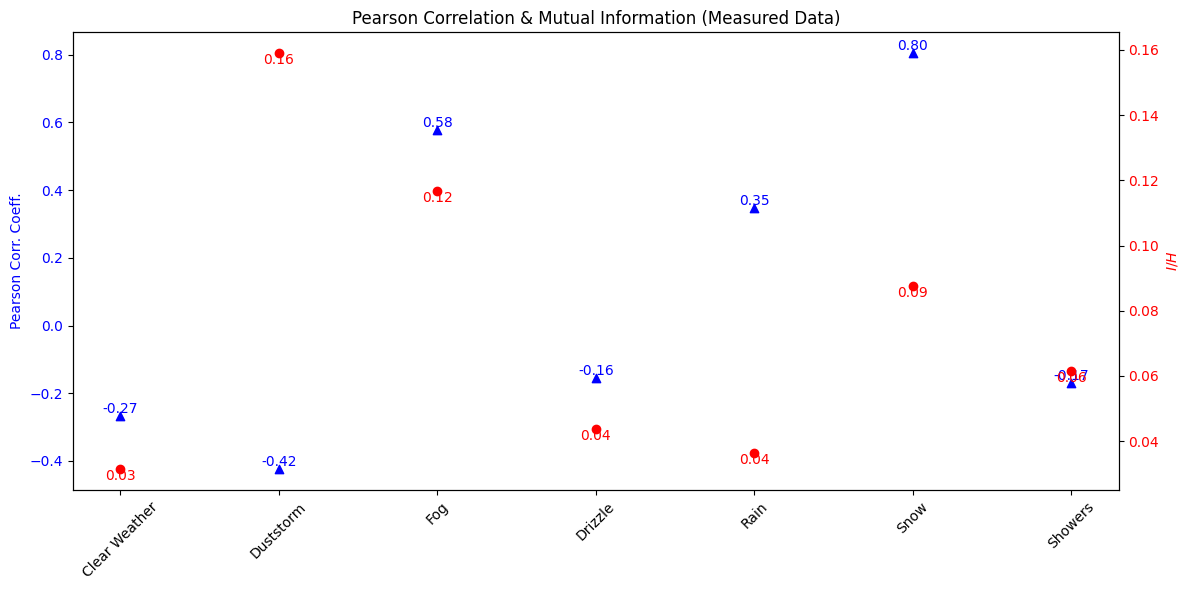

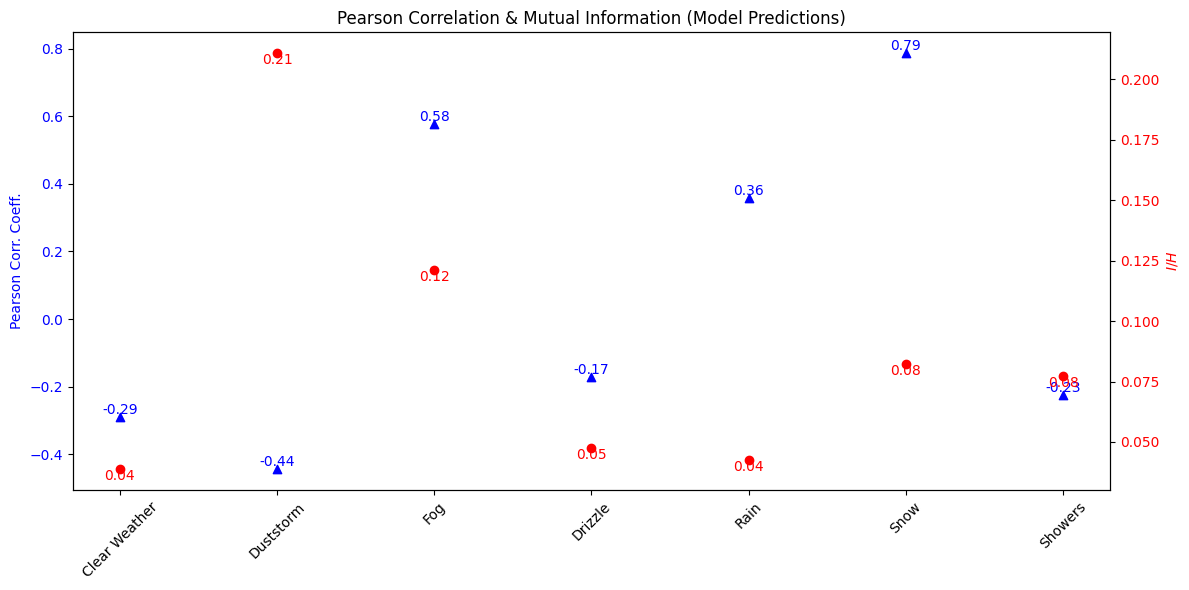

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr

# ✅ 1. 初始化存储结果的列表
weather_conditions = []

# 真实数据计算
pearson_corr_list_real = []
mutual_info_list_real = []

# 模型预测计算
pearson_corr_list_model = []
mutual_info_list_model = []

rf_rmse_list = []
rf_r2_list = []
fso_rmse_list = []
fso_r2_list = []

for code, label in weather_mapping.items():
    subset = data[data['SYNOPCode'] == code]
    if len(subset) < 10:
        continue  # 数据量太少，跳过

    # ✅ 2. 拆分子集特征 & 目标
    X_sub = subset.drop(['RFL_Att', 'FSO_Att'], axis=1)
    y_rf_sub = subset['RFL_Att']
    y_fso_sub = subset['FSO_Att']

    # ✅ 3. 真实数据计算 Pearson 相关性 & 互信息
    p_corr_real, _ = pearsonr(y_rf_sub, y_fso_sub)
    mi_value_real = mutual_info_regression(y_rf_sub.values.reshape(-1, 1), y_fso_sub)[0]
    mi_norm_real = mi_value_real / np.log(len(X_sub))

    # ✅ 4. 预测数据计算
    try:
        X_sub_rf = X_sub[rf_selected_features]
    except KeyError as e:
        print(f"[Warning] {label} - Missing feature in RF model: {e}")
        continue

    # 预测 RF 衰减
    rf_sub_pred = rf_model.predict(X_sub_rf)
    
    # 在特征集中加入 Predicted_RF_Att
    X_sub_new = X_sub_rf.copy()
    X_sub_new['Predicted_RF_Att'] = rf_sub_pred

    try:
        X_sub_fso = X_sub_new[fso_selected_features]
    except KeyError as e:
        print(f"[Warning] {label} - Missing feature in FSO model: {e}")
        continue

    # 预测 FSO 衰减
    fso_sub_pred = fso_model.predict(X_sub_fso)

    # 计算 RF 和 FSO 的 RMSE 和 R²
    rf_rmse = np.sqrt(mean_squared_error(y_rf_sub, rf_sub_pred))
    rf_r2 = r2_score(y_rf_sub, rf_sub_pred)
    fso_rmse = np.sqrt(mean_squared_error(y_fso_sub, fso_sub_pred))
    fso_r2 = r2_score(y_fso_sub, fso_sub_pred)

    # ✅ 5. 预测数据计算 Pearson 相关性 & 互信息
    p_corr_model, _ = pearsonr(rf_sub_pred, fso_sub_pred)
    mi_value_model = mutual_info_regression(rf_sub_pred.reshape(-1, 1), fso_sub_pred)[0]
    mi_norm_model = mi_value_model / np.log(len(X_sub_new))

    # ✅ 6. 存储结果
    weather_conditions.append(label)

    pearson_corr_list_real.append(p_corr_real)
    mutual_info_list_real.append(mi_norm_real)

    pearson_corr_list_model.append(p_corr_model)
    mutual_info_list_model.append(mi_norm_model)

    rf_rmse_list.append(rf_rmse)
    rf_r2_list.append(rf_r2)
    fso_rmse_list.append(fso_rmse)
    fso_r2_list.append(fso_r2)

# ✅ 7. 画图
def plot_correlation(weather_conditions, pearson_corr_list, mutual_info_list, title):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Pearson Correlation (左侧轴)
    ax1.set_ylabel('Pearson Corr. Coeff.', color='blue')
    ax1.scatter(weather_conditions, pearson_corr_list, color='blue', label='Pearson Corr', marker='^')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Mutual Information (右侧轴)
    ax2 = ax1.twinx()
    ax2.set_ylabel(r'$I / H$', color='red')
    ax2.scatter(weather_conditions, mutual_info_list, color='red', label='Mutual Info (norm)', marker='o')
    ax2.tick_params(axis='y', labelcolor='red')

    # 标注数值
    for i, label in enumerate(weather_conditions):
        ax1.text(i, pearson_corr_list[i], f'{pearson_corr_list[i]:.2f}', ha='center', va='bottom', color='blue')
        ax2.text(i, mutual_info_list[i], f'{mutual_info_list[i]:.2f}', ha='center', va='top', color='red')

    ax1.set_xticks(range(len(weather_conditions)))
    ax1.set_xticklabels(weather_conditions, rotation=45)
    ax1.set_title(title)
    fig.tight_layout()
    plt.show()

# ✅ 8. 绘制真实数据图
plot_correlation(weather_conditions, pearson_corr_list_real, mutual_info_list_real, 
                 'Pearson Correlation & Mutual Information (Measured Data)')

# ✅ 9. 绘制模型预测数据图
plot_correlation(weather_conditions, pearson_corr_list_model, mutual_info_list_model, 
                 'Pearson Correlation & Mutual Information (Model Predictions)')


In [ ]:
print(results_df)


In [21]:
print(f"rf_rmse_list type: {type(rf_rmse_list)}, length: {len(rf_rmse_list)}")
print(f"fso_rmse_list type: {type(fso_rmse_list)}, length: {len(fso_rmse_list)}")
print(f"rf_rmse_list content: {rf_rmse_list}")
print(f"fso_rmse_list content: {fso_rmse_list}")


rf_rmse_list type: <class 'list'>, length: 7
fso_rmse_list type: <class 'list'>, length: 7
rf_rmse_list content: [np.float64(0.3329549849333184), np.float64(0.4307958355022841), np.float64(0.28400222268356334), np.float64(0.3618228031815672), np.float64(0.5509909291966667), np.float64(0.36377491585032246), np.float64(0.6442144867480692)]
fso_rmse_list content: [np.float64(0.82488040858343), np.float64(1.686999547277229), np.float64(0.7355083726939825), np.float64(0.7657295646488499), np.float64(0.7756779545506955), np.float64(1.007523487192932), np.float64(0.7446294424240059)]


In [22]:
rf_att_values = np.array(rf_rmse_list)  # 直接转换为 NumPy 数组
fso_att_values = np.array(fso_rmse_list)  # 直接转换为 NumPy 数组


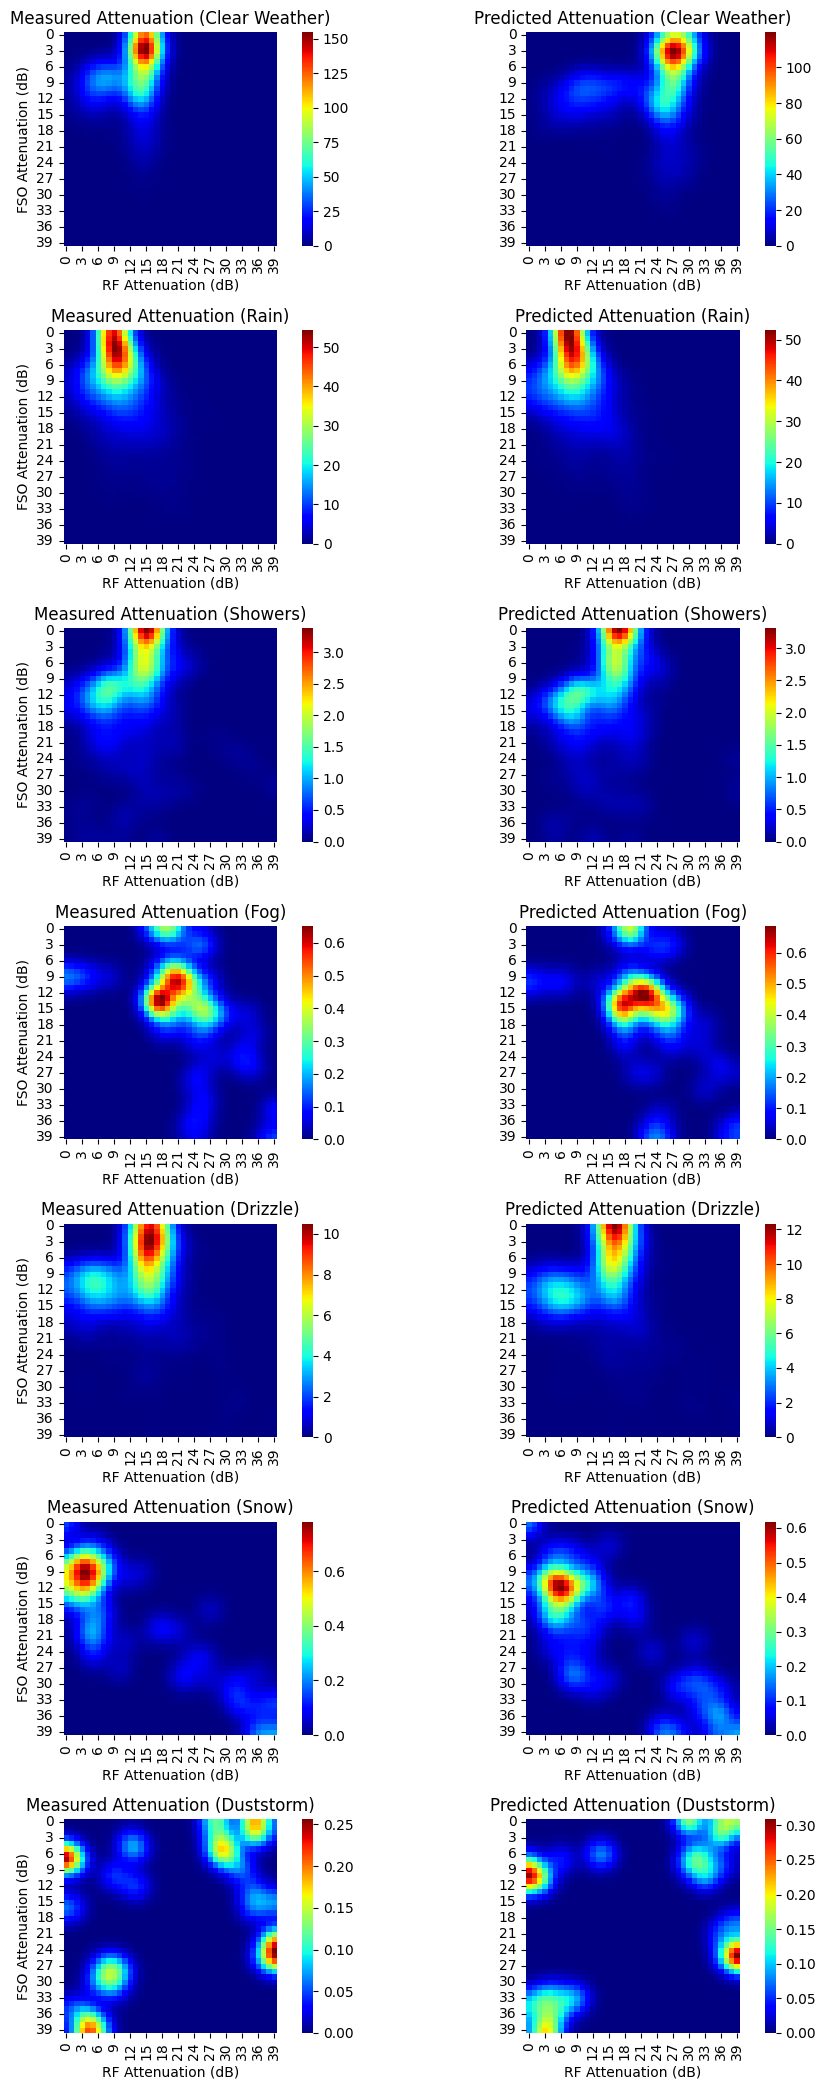

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter

# ✅ 1. 确保 `Measured` 和 `Predicted` 只使用测试集
test_data = data.loc[X_test.index]  # 只选测试集数据
weather_conditions = test_data["SYNOPCode"].unique()  # 仅使用测试集中存在的天气类型
num_conditions = len(weather_conditions)

# ✅ 2. 生成 `Predicted_RF_Att`，确保 `X_test_new` 和训练时一致
X_test_new = X_test_rf.copy()
X_test_new["Predicted_RF_Att"] = rf_model.predict(X_test_rf)

# ✅ 3. 创建子图（每个天气两列：Measured vs. Predicted）
fig, axes = plt.subplots(num_conditions, 2, figsize=(10, num_conditions * 3))

for i, weather_code in enumerate(weather_conditions):
    subset_indices = test_data[test_data["SYNOPCode"] == weather_code].index  # 筛选该天气的数据索引
    
    if len(subset_indices) < 10:  # 数据量过少，跳过
        continue

    # ✅ 4. 获取 `Measured` 数据
    measured_rf_subset = y_rf_test.loc[subset_indices].values
    measured_fso_subset = y_fso_test.loc[subset_indices].values

    # ✅ 5. 确保 `X_test_new` 仅包含 `fso_selected_features`
    X_test_fso_subset = X_test_new.loc[subset_indices, fso_selected_features]

    # ✅ 6. 进行预测（防止特征不匹配错误）
    predicted_rf_subset = rf_model.predict(X_test_rf.loc[subset_indices])
    predicted_fso_subset = fso_model.predict(X_test_fso_subset)

    # ✅ 7. 计算 2D 直方图（Measured）
    bin_size = 40
    measured_heatmap, x_edges, y_edges = np.histogram2d(measured_rf_subset, measured_fso_subset, bins=bin_size)
    measured_heatmap = gaussian_filter(measured_heatmap, sigma=2.0)  # 平滑处理

    # ✅ 8. 计算 2D 直方图（Predicted）
    predicted_heatmap, _, _ = np.histogram2d(predicted_rf_subset, predicted_fso_subset, bins=bin_size)
    predicted_heatmap = gaussian_filter(predicted_heatmap, sigma=2.0)

    # ✅ 9. 绘制 `Measured` 热图
    ax1 = axes[i, 0]
    sns.heatmap(measured_heatmap.T, cmap="jet", cbar=True, square=True, ax=ax1)
    ax1.set_title(f"Measured Attenuation ({weather_mapping.get(weather_code, 'Unknown')})")
    ax1.set_xlabel("RF Attenuation (dB)")
    ax1.set_ylabel("FSO Attenuation (dB)")

    # ✅ 10. 绘制 `Predicted` 热图
    ax2 = axes[i, 1]
    sns.heatmap(predicted_heatmap.T, cmap="jet", cbar=True, square=True, ax=ax2)
    ax2.set_title(f"Predicted Attenuation ({weather_mapping.get(weather_code, 'Unknown')})")
    ax2.set_xlabel("RF Attenuation (dB)")

plt.tight_layout()
plt.show()


